# Mouse Experiment

Create an AIXI mode to solve mazes where the maze is not known.  The idea is to sample EV from all enviroments consistent with our history weighted by the universal prior.  

**Details and Constraints**
* Grid worlds of random unbounded size, something like ~Poisson(10)
* I will use LZ as a proxy for kolgomov complexity
* The actual mazes will be taken from maze-lab (https://github.com/zuoxingdong/mazelab)
* I will assume a random starting location and random end location.

I can compare this to DFS and see how efficent it is.
I could also make it more complex by adding random teleporters, and hidden switches that open / close walls.  I think random teleporters would cause DFS to fail and we would no longer know our current state.

What if I added food and 'traps' or something.

Also, the best way to do this would be to run on various tests
Complex maze, simple maze, open world, lots of food, something like that.  Show how AIXI solves all these problems and DFS breaks (say with teleportation?)

In [364]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import zlib

# notes on compression algorithms
# LZMA seemed to increase size in blocks of 32 bytes, which wasn't good.

FIXED_SIZE = 6
DEBUG_LAST_SAMPLE_ITERATIONS = 0

class Maze():
    
    def __init__(self):
        self.width = FIXED_SIZE
        self.height = FIXED_SIZE
        self.field = np.zeros((self.width,self.height))
        self.start = (0,0)
        self.goal = (0,0)
        
    def complexity(self):
        """ The complexity of the maze. """
        return approx_kolmogorov(self.field.tobytes())
            
    def Generate():
        """ Generate a random map. """
        maze = Maze()
        maze.width = FIXED_SIZE
        maze.height = FIXED_SIZE
        maze.field = np.random.randint(0,2,(maze.width,maze.height), dtype=np.byte)
        maze.start = (np.random.randint(maze.width), np.random.randint(maze.height))
        maze.finish = (np.random.randint(maze.width), np.random.randint(maze.height))                
        return maze    
    
    def is_solvable(self):
        """ Returns if maze can be solved or not. """
        pass
    
    def display(self):
        pass

def approx_kolmogorov(X):
    """ Estimate Kolmogorov complexity using LZMA. """
    # note, this really should be *8 but by doing that 1 byte difference in encoding gives a probability
    # ratio of 256 which is too hard to sample.
    return len(zlib.compress(X,9))

def sample_random_maze():
    """ Sample maze from posterior via rejection sampling. """
    
    global DEBUG_LAST_SAMPLE_ITERATIONS
            
    # we generate a maze via the uniform distribution, then use rejection
    # sampling to get a sample from the true distribution.
    
    # g is our approximating distribution which is uniform all maze
    # states of a given size (and poisson over sizes)
    
    # assume empty map is the easyest to compress.
    M_log = -Maze().complexity() + (FIXED_SIZE*FIXED_SIZE)
    
    max_ratio = float('-inf')
    
    for i in range(1000000):
        maze = Maze.Generate()
        f_log_maze = -maze.complexity()
        g_log_maze = -(maze.width*maze.height)
        u = np.random.rand()
        log_ratio = f_log_maze - (M_log + g_log_maze)
        max_ratio = max(max_ratio, log_ratio)
        ratio = 2**log_ratio        
        if ratio > 1:
            print("Ratio too high! log_ratio={} f_log_maze={} M_log = {} g_log_maze = {} ".format(log_ratio, f_log_maze, M_log, g_log_maze))
        if u < ratio:
            DEBUG_LAST_SAMPLE_ITERATIONS = i
            return maze
        
    DEBUG_LAST_SAMPLE_ITERATIONS = float('nan')
        
    raise Exception("Rejection sampling failed, best was log_ratio={}.".format(max_ratio))

14
30.4515 38 26
33.5485 26 38


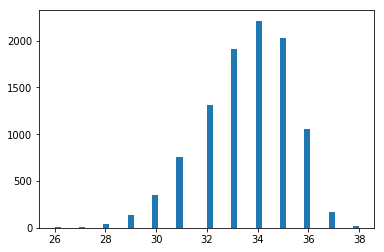

In [349]:
print(Maze().complexity())

# check distribution of complexities, make sure compression algorithm isn't working in blocks of bytes.

results = []
bits_results = []
for i in range(10000):
    maze = Maze.Generate()
    bits = maze.complexity()
    f_log_maze = -bits
    g_log_maze = -(maze.width*maze.height)
    results.append(f_log_maze - g_log_maze)
    bits_results.append(bits)
print(np.mean(results), np.max(results), np.min(results))
print(np.mean(bits_results), np.min(bits_results), np.max(bits_results))

plt.hist(bits_results, bins=50)
plt.show()
    

In [365]:
# make sure sampling works
# idea to to make sure ratio isn't too high, and that we always achieve a sample
sample_it = []
for i in range(1000):    
    sample_random_maze()
    sample_it.append(DEBUG_LAST_SAMPLE_ITERATIONS)
print(np.mean(sample_it))

1901.667


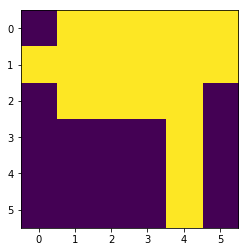

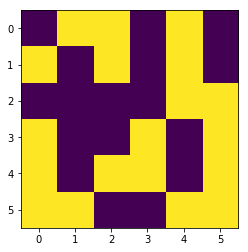

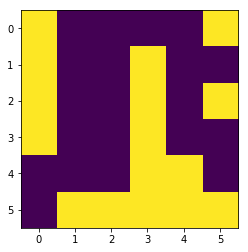

In [366]:
def display_maze(self):
    plt.imshow(self.field)
    plt.show()
    
# show some examples
for i in range(3):
    display_maze(sample_random_maze())
    

0.0 4.25323486328125 2.4554125467936196


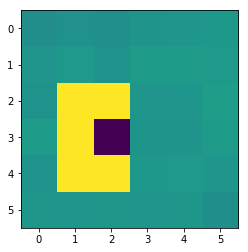

In [430]:
# try to solve a specific maze

# The idea here is to try to find maps that are consistent with our observations and history.  
# If we center the starting location we will effectively be mapping the enviroment

# how is this better than simply mapping enviroment?  What enviroments can I deal with that would be hard to solve otherwise?
# maybe I need a better hiden state game... something more akin to starcraft.


# main problem here is I'm assuming a grid world, if this is the case it's easy to solve using other methods... :(
# some kind of game that has hidden state (poker) would be better... but even then you know the dynamics.  I need
# a game where the dynamics are unknown...  Maybe poker could work, if I just don't tell it it's playing poker...

# need to do
# some function to take an observation
# some function to sample worlds and plot

# idea? Use image compression? or some kind of block compression?

accumulator = Maze().field
reference_level = Maze().complexity()

for i in range(500000):
    maze = Maze.Generate()
    if maze.field[2,1] != 1:
        continue
    if maze.field[2,2] != 1:
        continue
    if maze.field[3,1] != 1:
        continue
    if maze.field[4,1] != 1:
        continue
    if maze.field[4,2] != 1:
        continue
    if maze.field[3,2] != 0:
        continue
    accumulator += maze.field * 2**-(maze.complexity() - reference_level)
    
print(np.min(accumulator), np.max(accumulator), np.mean(accumulator))
    
plt.imshow(accumulator)
plt.show()
    